In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

%matplotlib notebook

In [3]:
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path
from astropy.coordinates.angle_utilities import angular_separation
from ctapipe.io import TableLoader
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz
from ctapipe.containers import ImageParametersContainer
from ctapipe.calib import CameraCalibrator
from ctapipe.image import ImageProcessor
from ctapipe.reco import ShowerProcessor
from ctapipe.io import DataWriter
from copy import deepcopy, copy
import tempfile
from ctapipe.visualization import CameraDisplay
from ctapipe.image import timing_parameters
from abc import ABC, abstractmethod

from ctapipe.instrument import SubarrayDescription, TelescopeDescription, CameraDescription, CameraGeometry
from ctapipe.containers import ArrayEventContainer
from astropy.time import Time
from scipy import stats
from ctapipe.calib.camera.gainselection import GainSelector
from ctapipe.image.toymodel import ImageModel
from ctapipe.image.toymodel import Gaussian
from ctapipe.image import ImageModifier

In [6]:
input_url = "gamma_20deg_0deg_run1555___cta-prod6-paranal-2147m-Paranal-dark-bs5.0-10k-lfa64.simtel.zst"
print(input_url)
source = EventSource(input_url)
subarray = source.subarray

calibrator = CameraCalibrator(subarray=source.subarray, image_extractor_type = 'FlashCamExtractor')

#Initiliaze arrays
mean_times = np.array([])
event_ids = np.array([])
tel_ids = np.array([])


for event in source:
    
    calibrator(event)
    
    for tel_id in (event.r0.tel.keys()):
        if tel_id in np.unique(events["MST_MST_FlashCam"]["tel_id"]):
            t = source.file_.current_photoelectrons[tel_id-1]['time']

            mean_time = np.array([])
            for pix_id in np.unique(source.file_.current_photoelectrons[tel_id-1]['pixel_id']):
                mean_time = np.append(mean_time, np.mean(t[source.file_.current_photoelectrons[tel_id-1]['pixel_id'] == pix_id]))
                tel_ids = np.append(tel_ids, tel_id)
                event_ids = np.append(event_ids, event.count)

            mean_time = mean_time - np.mean(mean_time)
            mean_times = np.append(mean_times, mean_time)

gamma_20deg_0deg_run1555___cta-prod6-paranal-2147m-Paranal-dark-bs5.0-10k-lfa64.simtel.zst


In [19]:
# FlashCam extractor.
loader = TableLoader("gamma_flatfield.dl1.h5", 
                     load_true_images = True, 
                     load_dl1_images = True,
                     load_dl1_parameters=False,
                    )     
events = loader.read_telescope_events_by_type()

#load_dl1_images, load_true_images, load_true_images, load_simulated)

In [20]:
events.keys()

dict_keys(['LST_LST_LSTcam', 'MST_MST_FlashCam', 'SST_SST_SST-Camera'])

In [21]:
tel_id = next(iter(event.dl1.tel.keys()))
print(tel_id)

22


In [22]:
events["MST_MST_FlashCam"]

obs_id,event_id,tel_id,image,peak_time,image_mask,is_valid,true_image_sum,true_image,time,tels_with_trigger,event_type
int32,int64,int16,float32[1764],float32[1764],bool[1764],bool,int32,int32[1764],Time,bool[87],int64
1555,1901,10,0.24893296 .. 4.171102,13.430633 .. 29.88083,False .. False,True,77,0 .. 0,59809.91045552352,False .. False,32
1555,1901,24,-3.747272 .. -3.7227454,63.396786 .. 67.77457,False .. False,True,67,0 .. 0,59809.91045552352,False .. False,32
1555,1901,30,2.996516 .. 2.0777884,9.455813 .. 86.80229,False .. False,True,90,0 .. 0,59809.91045552352,False .. False,32
1555,5503,23,-1.3514255 .. -3.8010073,55.825504 .. 88.125015,False .. False,True,739,0 .. 0,59809.9115809982,False .. False,32
1555,5503,31,0.025709258 .. -1.6471455,64.6115 .. -0.21908846,False .. False,True,1171,0 .. 0,59809.9115809982,False .. False,32
1555,5506,26,-0.6796841 .. 8.6066,39.279453 .. 42.361904,False .. True,True,3226,0 .. 9,59809.91160117771,False .. False,32
...,...,...,...,...,...,...,...,...,...,...,...
1555,992402,37,-1.38633 .. -1.1897815,92.28829 .. 60.06993,False .. False,True,155,0 .. 0,59809.94507016162,True .. False,32
1555,992404,12,7.257139 .. -4.2940187,20.914114 .. 11.973875,False .. False,True,96,0 .. 0,59809.94508557321,False .. False,32


In [23]:
#Add extra noise

#add_noise = ImageModifier(
#    source.subarray,
#    noise_level_bright_pixels=5,
#    noise_level_dim_pixels=5,
#)

#Disabled pixels
flashcam_disabled_pixels = event.mon.tel[tel_id].pixel_status.hardware_failing_pixels[0]
print(flashcam_disabled_pixels)

[False False False ... False False False]


# CHARGE RESOLUTION

In [24]:
# Good pixels

true_pe = np.array([])
recon_pe = np.array([])
recon_mean = np.array([])

for tel_type, table in events.items():
    if tel_type == 'MST_MST_FlashCam':
            good_pixels = ~flashcam_disabled_pixels
    else:
        good_pixels = slice(None)
        
    images = table["image"]
    true_images = table["true_image"]
    
    pixel_values = images[:, good_pixels]
    true_pixel_values = true_images[:, good_pixels]
    good_times = table["peak_time"][:, good_pixels]
    
    noise = pixel_values[true_pixel_values == 0]
    
    if tel_type == 'MST_MST_FlashCam':
        true_pe = np.append(true_pe, true_pixel_values[true_pixel_values > 0])
        recon_pe = np.append(recon_pe, pixel_values[true_pixel_values > 0])
        recon_mean = np.append(recon_mean, good_times[true_pixel_values > 0])
        

In [25]:
def compute_profile(x, y, nbin=(100,100)):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

<IPython.core.display.Javascript object>


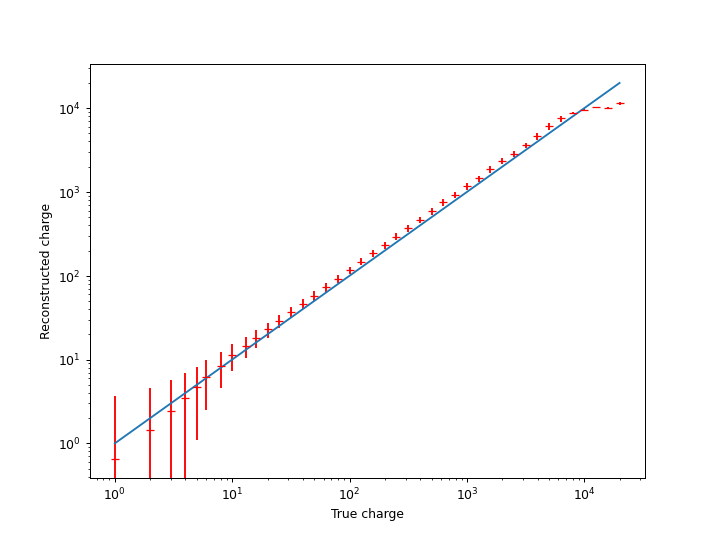

In [26]:
bins=np.unique(np.round(np.logspace(0, 5, 51))) - 0.5   #Logarithmic binning

p_x, p_mean, p_rms = compute_profile(true_pe, recon_pe, (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True charge")
plt.ylabel("Reconstructed charge")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.plot(p_x, p_x)
plt.show()

<IPython.core.display.Javascript object>


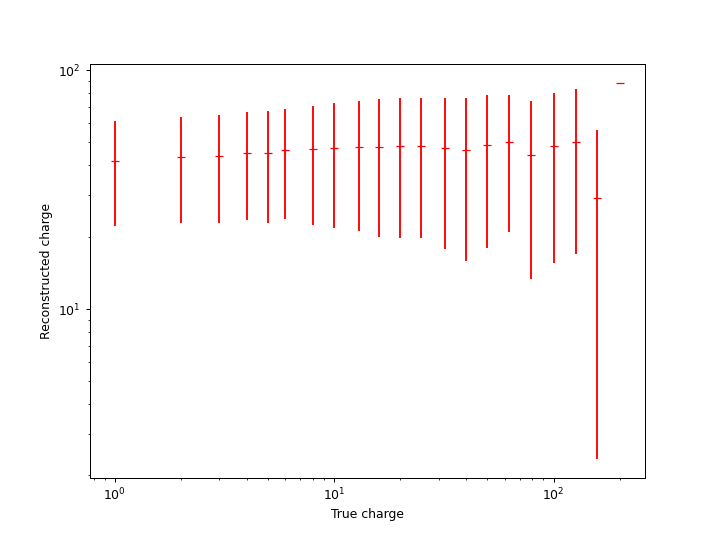

In [27]:
p_x, p_mean, p_rms = compute_profile(mean_times, recon_mean, (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True charge")
plt.ylabel("Reconstructed charge")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.show()

<IPython.core.display.Javascript object>


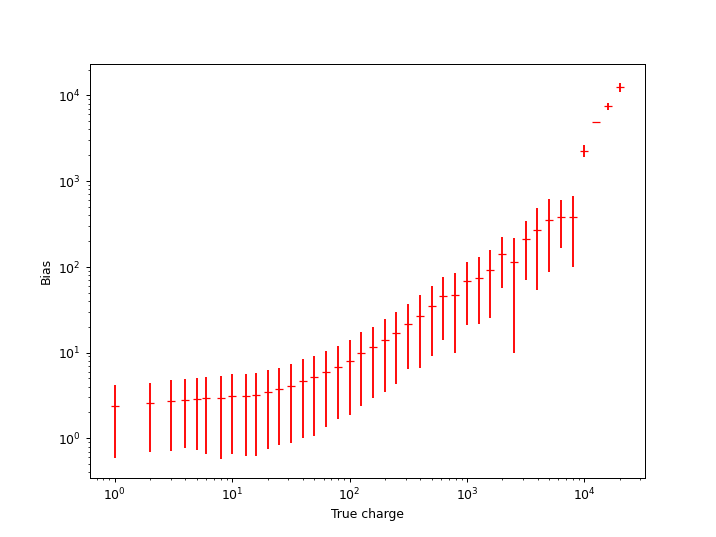

In [28]:
p_x, p_mean, p_rms = compute_profile(true_pe, np.abs(recon_pe-true_pe), (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True charge")
plt.ylabel("Bias")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.show()

<IPython.core.display.Javascript object>


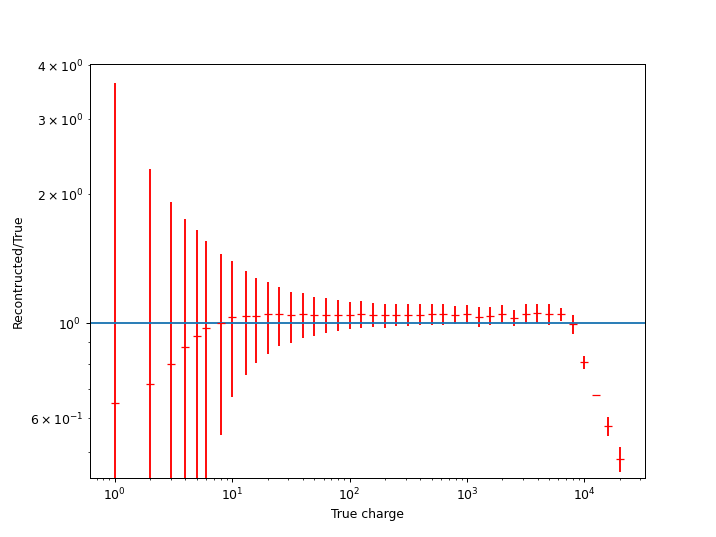

In [29]:
p_x, p_mean, p_rms = compute_profile(true_pe, recon_pe/true_pe, (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Recontructed/True")
plt.xlabel("True charge")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.axhline(y=1)
plt.show()

<IPython.core.display.Javascript object>


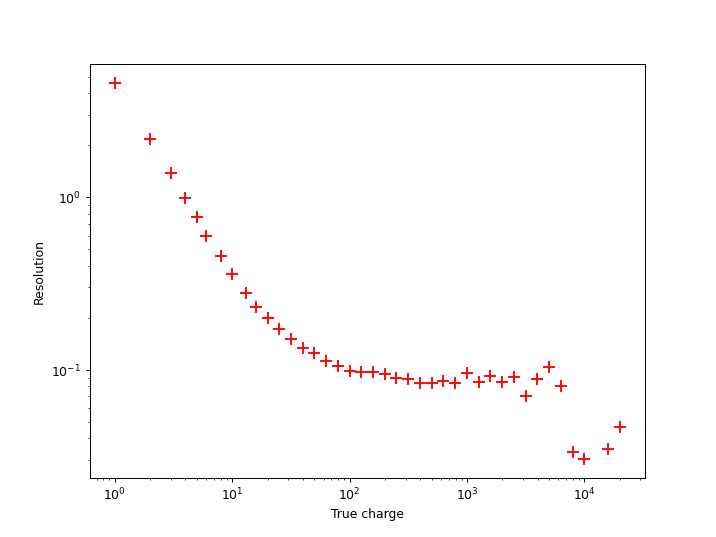

In [30]:
p_x, p_mean, p_rms = compute_profile(true_pe, recon_pe, (bins,bins))

plt.figure(figsize=(8, 6))

plt.scatter(p_x, p_rms/p_mean, color='red', marker='+', s=80)

plt.xscale('log')
plt.yscale('log')
plt.ylabel("Resolution")
plt.xlabel("True charge")
plt.show()

<IPython.core.display.Javascript object>


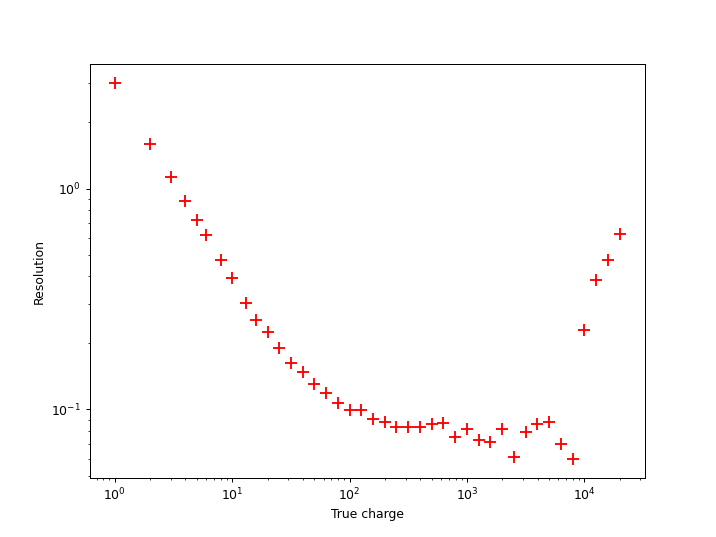

In [31]:
# Resolution with RMS

p_x, p_mean, p_rms = compute_profile(true_pe, (recon_pe-true_pe)**2, (bins,bins))


plt.figure(figsize=(8, 6))

plt.scatter(p_x, np.sqrt(p_mean)/p_x, color='red', marker='+', s=80)

plt.xscale('log')
plt.yscale('log')
plt.ylabel("Resolution")
plt.xlabel("True charge")
plt.show()

<IPython.core.display.Javascript object>


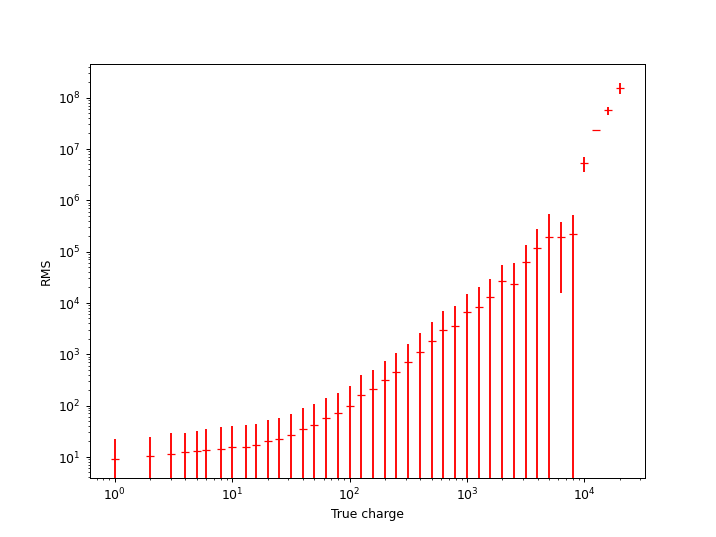

In [18]:
# RMS

p_x, p_mean, p_rms = compute_profile(true_pe, (recon_pe-true_pe)**2, (bins,bins))

plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
plt.ylabel("RMS")
plt.xlabel("True charge")
plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='r', color='r')
plt.show()